## Overview of Model Training on cleaned data

#### Import Libraries

In [1]:
#pip install feature_engine --user
# !pip install xgboost --user

In [2]:
import numpy as np
import pandas as pd
import sklearn 
import joblib
import matplotlib.pyplot as plt
import os

C:\Users\nilas\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.datetime import DatetimeFeatures

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
# from xgboost import XGBRegressor

In [5]:
pd.set_option("display.max_columns",None)

In [6]:
sklearn.set_config(transform_output="pandas")

#### Import Data

In [7]:
project_dir=r"C:\Users\nilas\Documents\Flask_ML_Project"
data_dir="Data"

In [8]:
def get_data(name):
    file_name=f"{name}.csv"
    file_path=os.path.join(project_dir,data_dir,file_name)
    return pd.read_csv(file_path)

In [9]:
train_df=get_data("train")
test_df=get_data("test")
val_df=get_data("val")

In [10]:
train_df.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187


In [11]:
#Split target and input feature columns

def feature_target(data):
    x=data.drop(columns='price')
    y=data.price.copy()
    return (x,y)

In [12]:
x_train,y_train=feature_target(train_df)
x_test,y_test=feature_target(test_df)
x_val,y_val=feature_target(val_df)

In [13]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


#### Data Pre-processing

In [14]:
dt_cols=['date_of_journey','dep_time','arrival_time']
num_cols=['duration','total_stops']
cat_cols=[col for col in x_train.columns if (col not in dt_cols)and (col not in num_cols)]

In [15]:
num_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

cat_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])  #to handle unknow category during cross-validation

date_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extractor",DatetimeFeatures(features_to_extract=["month","week","day_of_week","day_of_month"], format="mixed")),
    ("scaler",StandardScaler())
])

time_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("extractor",DatetimeFeatures(features_to_extract=["hour","minute"], format="mixed")),
    ("scaler",StandardScaler())
])


In [16]:
preprocessor=ColumnTransformer(transformers=[
    ("num",num_transformer, num_cols),
    ("cat",cat_transformer, cat_cols),
    ("date",date_transformer, ['date_of_journey']),
    ("time",time_transformer,['dep_time','arrival_time'])
])

In [17]:
preprocessor.fit_transform(x_train)

,num__duration,num__total_stops,cat__airline_Air Asia,cat__airline_Air India,cat__airline_Goair,cat__airline_Indigo,cat__airline_Jet Airways,cat__airline_Multiple Carriers,cat__airline_Spicejet,cat__airline_Vistara,cat__source_Banglore,cat__source_Chennai,cat__source_Delhi,cat__source_Kolkata,cat__source_Mumbai,cat__destination_Banglore,cat__destination_Cochin,cat__destination_Delhi,cat__destination_Hyderabad,cat__destination_Kolkata,cat__destination_New Delhi,cat__additional_info_1 Long layover,cat__additional_info_In-flight meal not included,cat__additional_info_No Info,cat__additional_info_No check-in baggage included,date__date_of_journey_month,date__date_of_journey_week,date__date_of_journey_day_of_week,date__date_of_journey_day_of_month,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute
0,-1.095918,-1.212132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.151587,1.331443,0.566118,0.963554,-0.462055,-0.140057,-0.345231,1.493859
1,1.435699,0.317975,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,1.050498,0.604465,-0.640951,-1.229863,-0.935607,0.891041
2,1.824412,1.848082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,1.140212,-0.402640,-0.113711,-0.640951,-0.684960,-0.345231,-1.218823
3,1.904148,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.772093,-1.371399,-1.430369,1.326906,-0.140057,1.278301,1.795268
4,0.847647,0.317975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.151587,0.948982,0.081739,-0.831888,0.790218,-1.229863,-0.492825,1.192450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-0.936446,-1.212132,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.538816,-0.580863,0.566118,-0.113711,-1.535432,1.767103,-0.935607,1.192450
636,0.100122,0.317975,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.184059,0.081739,-0.472800,-0.640951,0.677297,1.130707,-1.218823
637,-0.946413,-1.212132,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-1.177640,-0.957412,-0.788013,1.493859
638,0.189825,0.317975,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.306386,0.375290,-0.402640,0.245377,-0.819847,1.222200,1.130707,-1.520232


#### Model Selection

In [18]:
algorithms={
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    }

In [19]:
data=pd.concat([train_df,val_df], axis=0)
x_data,y_data=feature_target(data)


In [20]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(sizes, mean_scores, marker='o',label=label)
    
    ax.fill_between(
    x=sizes,
    y1=mean_scores-std_scores,
    y2=mean_scores+std_scores,
    alpha=0.5
    )

In [21]:
def plot_learning_curve(name, algorithm, figsize=(12,4)):
    model=Pipeline(steps=[
        ("pre",preprocessor),
        ("algo",algorithm),
        ])
    train_sizes, train_scores, test_scores=learning_curve(
    estimator=model,
    X=x_data,
    y=y_data,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    random_state=42
    )
    
    mean_train_scores=np.mean(train_scores,axis=1)
    std_train_scores=np.std(train_scores,axis=1)
    train_score=f"{mean_train_scores[-1]:.2f}+/-{std_train_scores[-1]:.2f}"
    
    mean_test_scores=np.mean(test_scores,axis=1)
    std_test_scores=np.std(test_scores,axis=1)
    test_score=f"{mean_test_scores[-1]:.2f}+/-{std_test_scores[-1]:.2f}"
    
    fig,ax=plt.subplots(figsize=figsize)
    
    #training curve
    plot_curves(
    train_sizes, mean_train_scores, std_train_scores, 
        f"Train({train_score})",ax)
    
      #test curve
    plot_curves(
    train_sizes, mean_test_scores, std_test_scores, 
        f"Test({test_score})",ax)
    
    ax.set(xlabel='Training Set Size', ylabel="R-square",title=name)
    ax.legend(loc="lower right")
    
    plt.show()

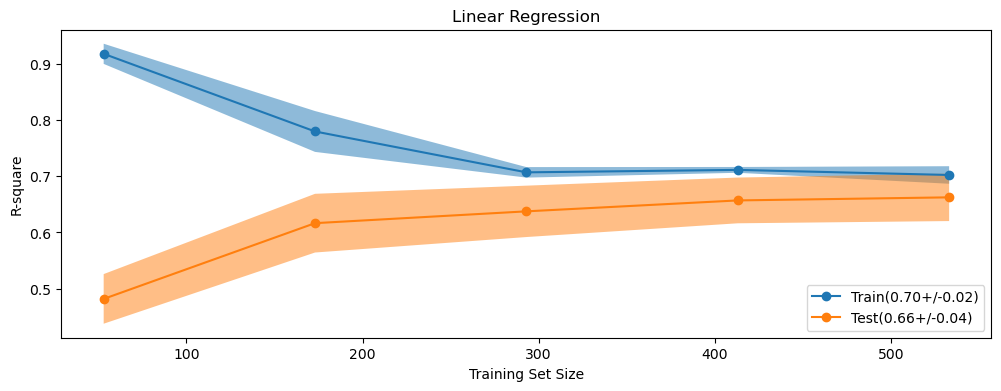

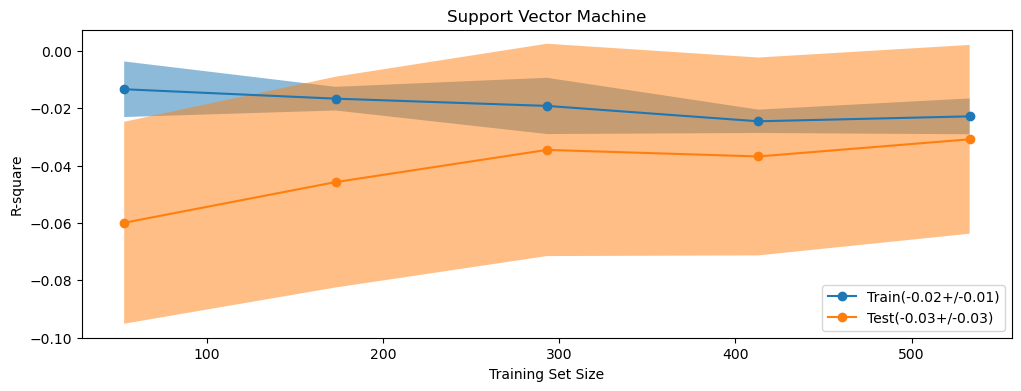

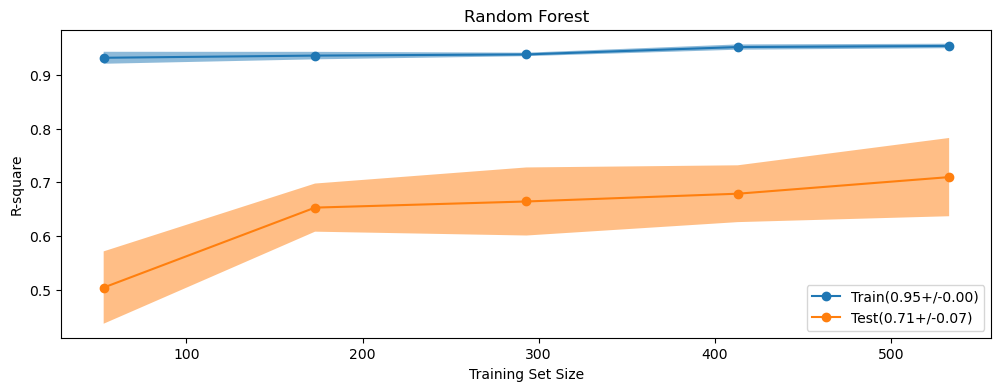

In [22]:
for name, algo in algorithms.items():
    plot_learning_curve(name,algo)

#### Model Training

In [23]:
model=Pipeline(steps=[
    ("pre",preprocessor),
    ("RF",RandomForestRegressor(n_estimators=10))
])

In [24]:
model.fit(x_data,y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('RF', RandomForestRegressor(n_estimators=10))])

#### Model Evaluation

In [25]:
def eval_model(x,y):
    y_pred=model.predict(x)
    return r2_score(y,y_pred)

In [26]:
print(f"R2 score on Training data is {eval_model(x_data,y_data)}")

R2 score on Training data is 0.9437493618527217


In [27]:
print(f"R2 score on Test data is {eval_model(x_test,y_test)}")

R2 score on Test data is 0.7194467831395892


#### Model Persistence

In [28]:
joblib.dump(model,"model.joblib")

['model.joblib']

In [29]:
saved_model=joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('RF', RandomForestRegressor(n_estimators=10))])

In [30]:
y_pred=saved_model.predict(x_test)

r2_score(y_test,y_pred)

0.7194467831395892